# Наивный Байесовский классификатор

Будем решать задачу классификации. Пусть $X \times Y$ является вероятностным пространством. Тренировочное множество $T^l=\{(x_i, y_i)\}_{i=1}^{l}$ полученно случайно и независимо согласно соответствующему распределению $p(x, y)$.

- $p(y)$ - априорные распределения классов
- $p(y|x)$ - апостериорные распределения классов

Пусть есть некоторый алгоритм классификации $a: X \rightarrow Y$. Введем функцию потери - $\lambda(y, w)$, если объект класса $y$ отнесен к классу $w$. Будем считать, что $\lambda(y, w) \ge 0$ и $\lambda(y, y) = 0$ . Физический смысл функции потери в том, что иногда ошибка в одну сторону более опасны, чем в другую (покупать акции или не покупать, сбивать самолет или не сбивать).

Байесовский риск для алгоритма $a$ определяется следующим функционалом:

$$R(a)=\sum_{y \in Y}{\int_{X}\lambda(y, a(x))p(y|x)p(x)dx}$$

Задача найти такой алгоритм $a$, который минимизирует этот функционал.

Если $$\lambda(y, w) = 
  \begin{cases} 
      \lambda_y & y \neq w \\
      0 & y = w 
  \end{cases}
$$
то на следующем алгоритме достигается минимум байесовского риска 

$$a_{MAP}(x) = \arg \max_{y \in Y} \lambda_y p(x|y)p(y) = \arg \max_{y \in Y} \lambda_y p(y|x) $$ 

Этот алгоритм называют *байесовским решающим правилом*.

Для того, чтобы применять алгоритм Байеса, нам нужно уметь оценивать $p(y)$ и $p(x|y)$. С первым можно сделать так:

$$T_{y}^{l} = \{(x_i, y_i) \in T^l | y_i = y\}$$

$$\hat{p} (y) = \frac{|T_{y}^l|} {l}$$

Во втором случае предположим, что признаки являются независимыми случайными величинами:

$$x \in X \rightarrow (f_1(x), \dots, f_n(x)) \rightarrow (x^1, \dots, x^n)$$

$$ \hat{p}(x|y) = \hat{p}_1(x^1|y) \cdot \ldots  \cdot \hat{p}_n (x^n|y) $$ 

где $p_k(x^k|y)$ - оценки плотности распределения $k$-го признака в зависимости от класса $y$.

Тогда перепишем байесовское решающее правило в виде, прологорифмировав выражение под максимум: 
$$ a_{MAP}(x) = \arg \max_{y \in Y} \big( \ln \lambda_y \hat{p} (y) +  \sum_{k=1}^{n}{\ln \hat{p} _{k}(x^k|y)} \big) $$

Осталось найти эти $\hat{p}_k (x_k|y)$ .

# Kernel Density Estimation (KDE)

Будем решать общую задачу, пусть есть *iid* выборка $(x_1, \dots, x_m)$ из некоторого распределения с неизвестной плотностью $p(x)$. Требуется найти некоторую эмпирическую оценку $\hat{p}$.

#### Дискретный случай
Эмпирическая функция вероятности:
$$\hat{p}(x) = \frac{1}{m}\sum_{i=1}^{m}[x_i=x]$$

#### Непрерывный случай
**Одномерное распределение**
Выберем некоторым параметр неотрицательный $h$, называемый шириной окна:

$$\hat{p}(x; h) = \frac{1}{2hm}\sum_{i=1}^{m}[|x - x_i| < h]$$

Эта функция кусочно-постоянна, что нехорошо. Используем более общий метод Парзена-Розенблата:

$$\hat{p}(x; h) = \frac{1}{hm}\sum_{i=1}^{m}K \bigg ( \frac{x - x_i}{h} \bigg ) $$

$K(t)$ - ядро, некая функция для которой выполняются условия: 
$$\int{K(t)dt} = 1$$ $$K(t) = K(-t)$$

Примеры ядер:
- гауссовское ядро
$$ K(t) \propto \exp \bigg (\frac{-t^2}{2} \bigg )$$
- прямоугольное ядро
$$ K(t) \propto [|t| < 1]$$
- ядро Епанечникова
$$ K(t) \propto 1 - t^2$$
- линейное ядро
$$ K(t) \propto \max(1 - |t|, 0)$$
- экспоненциальное
$$ K(t) \propto \exp \big( -|t| \big) $$
- косинусное
$$ K(t) \propto \max \big (\cos (\frac{\pi}{2} t ), 0 \big ) $$

**Многомерное распределение**
В многомерном случае есть два варианта:
1. Представить общую многомерную плотность в виде произведения многомерных плотностей: 
$$ \hat{p}(x; h_1, \ldots, h_n) = \frac{1}{m} \sum_{i=1}^{m} \prod_{k = 1}^{n} \frac{1}{h_k}K \bigg (\frac{x^k - x_{i}^{k}}{h_k} \bigg)$$ 

2. Если в пространстве задана метрика $\rho(x, w)$, то формулу для одномерного случая можно обобщить:

$$\hat{p}(x; h) = \frac{1}{m C(h)}\sum_{i=1}^{m}K \bigg ( \frac{\rho(x, x_i)}{h} \bigg ) $$

$C(h)$ - это нормирующий множитель, зависящий от $h$.

Ширину окна, $h$, как и ядро, можно подбирать, например, с помощью кросс-валидации. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

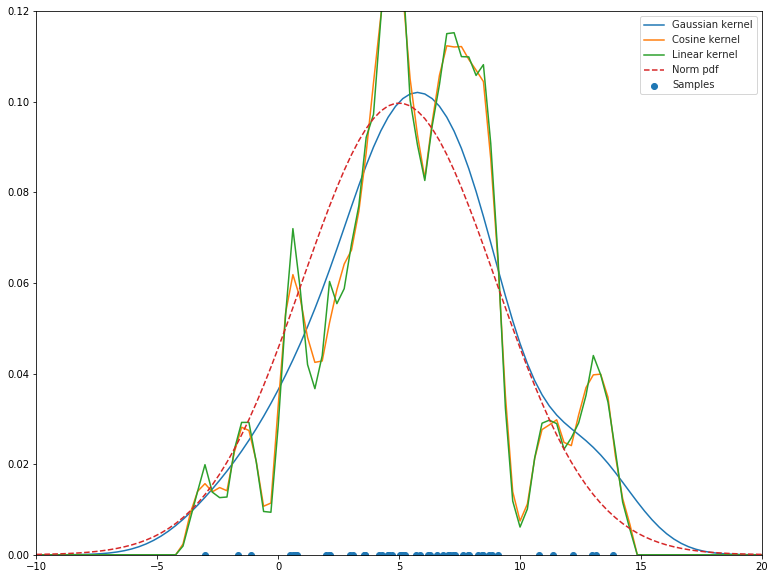

In [2]:
import scipy.stats
import sklearn

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

from scipy.stats import norm
from numpy.random import normal as sample_normal

def kde_via_sklearn(samples, x, kernel='gaussian'):
    kde_sklearn = KernelDensity(kernel=kernel).fit(samples.reshape((-1, 1)))
    return np.exp( kde_sklearn.score_samples(x.reshape((-1, 1))) ) 
    

x = np.linspace(-10, 20, 100)
norm_pdf = np.array([norm.pdf(el, 5, 4) for el in x])

samples = sample_normal(5, 4, 50)

# scipy
kde_scipy = gaussian_kde(samples).evaluate(x)
# sklearn
kde_sklearn_cosine = kde_via_sklearn(samples, x, 'cosine')
kde_sklearn_linear = kde_via_sklearn(samples, x, 'linear')

plt.figure(figsize=(13,10))

plt.scatter(samples, np.zeros_like(samples))

plt.plot(x, kde_scipy)
plt.plot(x, kde_sklearn_cosine)
plt.plot(x, kde_sklearn_linear)
plt.plot(x, norm_pdf, '--')
#plt.plot(x, norm.pdf(x, np.mean(samples), np.sqrt(np.var(samples))), '.')

plt.xlim((-10, 20))
plt.ylim((0, 0.12))

sns.set_style("whitegrid")
plt.legend(['Gaussian kernel', 'Cosine kernel', 'Linear kernel', 'Norm pdf', 'Samples'])

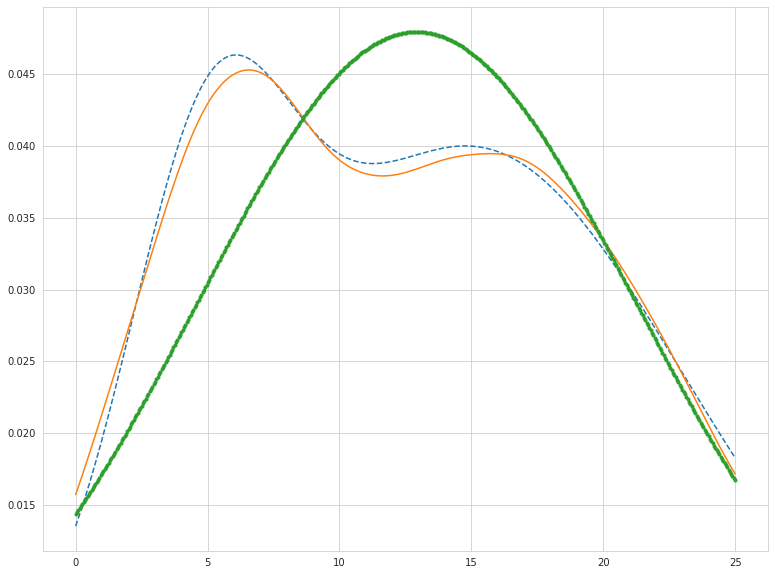

In [3]:
from numpy.random import normal as sample_normal
samples = np.concatenate((sample_normal(5, 3, 2000), sample_normal(15, 8, 8000)))

x = np.linspace(0, 25, 500)

plt.figure(figsize=(13,10))

kde = gaussian_kde(samples)
plt.plot(x, 0.2 * norm.pdf(x, 5, 3) + 0.8 * norm.pdf(x, 15, 8), '--')
plt.plot(x, kde(x))
plt.plot(x, norm.pdf(x, np.mean(samples), np.sqrt(np.var(samples))), '.')

# Многомерное нормальное распределение

Многомерная случайная величина имеет многомерное нормальное распределение с матожиданием $\mu \in \mathbb{R}^n$ и ковариационной матрицей $\Sigma$ (положительная, невырожденная, положительно определенная), если её плотность равна:

$$ p(x; \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^{n} \det(\Sigma)}} \exp \bigg(- \frac{(x - \mu)^T \Sigma^{-1}(x - \mu)}{2} \bigg)$$

$$x \sim \mathcal{N}(\mu, \Sigma)$$

$\DeclareMathOperator{\diag}{diag}$
Если $\Sigma=\diag(\sigma_{1}^2, \ldots, \sigma_{n}^2)$, то плотность многомерного нормального распределения может быть представлена в виде произведения плонтностей соответствующих нормальных распределений с матожиданиями $\mu_i$ и дисперсиями $\sigma_i$ .


Если $x \sim \mathcal{N}(\mu, \Sigma)$, то существует такая матрица $B$, что при преобразовании $z = B^{-1}(x - \mu)$ получается $z \sim \mathcal{N}(0, I)$ . Такое преобразование называется *декоррелирующим*. 

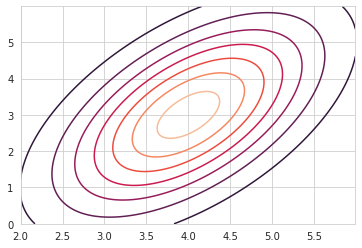

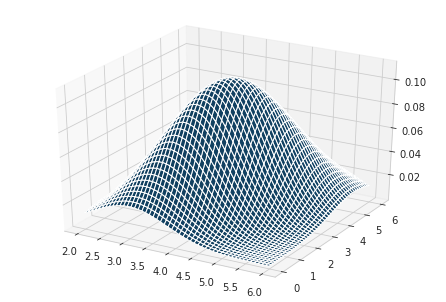

In [4]:
from scipy.stats import multivariate_normal

E = np.array([[1, 1], 
              [1, 3]])
mean = np.array([4, 3])

x, y = np.mgrid[2:6:.01, 0.:6.:.01]
xy = np.dstack((x, y))
rv = multivariate_normal(mean, E)

plt.contour(x, y, rv.pdf(xy))


from mpl_toolkits.mplot3d.axes3d import *
fig = plt.figure()
axes = Axes3D(fig)
axes.plot_surface(x, y, rv.pdf(xy))

Пусть есть выборка $(x_1, \dots, x_m)$. Можно посчитать оценку матожидания и несмещенную оценку дисперсии для многомерного нормального распределения:

$$\hat{\mu} = \frac{1}{m}\sum_{1}^{m}{x_i}$$
$$\hat{\Sigma} = \frac{1}{m-1}\sum_{1}^{m}{(x_i-\hat{\mu})(x_i-\hat{\mu})^T}$$

Вернёмся к баесовскому классивикатору:
$$a_{MAP}(x) = \arg \max_{y \in Y} \lambda_y p(x|y)p(y)$$

#### Нормальный байесовский классификатор 
Считаем $\hat{\mu}_y$ и $\hat{\Sigma}_y$ для каждого класса, дальше соответственно
$$\hat{p}(x|y) \sim \mathcal{N}(\hat{\mu}_y, \hat{\Sigma}_y)$$

Найдем вид для разделяющей поверхности между классами. Пусть есть класс $d$ и $t$. На ГМТ разделяющей поверхности выполняется:

$\newcommand\textequal{\rule[.4ex]{4pt}{0.4pt}\llap{\rule[.7ex]{4pt}{0.4pt}}}$

$$\lambda_d \hat{p}(x|y=d) \hat{p}(y=d) = \lambda_t \hat{p}(x|y=t) \hat{p}(y=t)$$

$$\ln \hat{p}(x|y=d) - \ln \hat{p}(x|y=t) = \ln \bigg( \frac{\lambda_t \hat{p}(y=t)}{\lambda_d \hat{p}(y=d)} \bigg) $$

$$ - \ln (det(\hat{\Sigma}_d)) - (x - \hat{\mu}_d)^T \hat{\Sigma}_d^{-1}(x - \hat{\mu}_d)
+ \ln (det(\hat{\Sigma}_t)) - (x - \hat{\mu}_t)^T \hat{\Sigma}_t^{-1}(x - \hat{\mu}_t) = 2 \ln \bigg( \frac{\lambda_t \hat{p}(y=t)}{\lambda_d \hat{p}(y=d)} \bigg)$$

В общем случае это квадратичная поверхность. Если предположить, что $\hat{\Sigma}_d  = \hat{\Sigma}_t = \hat{\Sigma} $ , то формула варождается в:

$$ x^T \hat{\Sigma}^{-1}(\hat{\mu}_d - \hat{\mu_t}) = \ln \bigg( \frac{\lambda_t \hat{p}(y=t)}{\lambda_d \hat{p}(y=d)} \bigg) + \frac{1}{2} \bigg (\hat{\mu}_d^T \hat{\Sigma}^{-1} \hat{\mu}_d - \hat{\mu}_t^T \hat{\Sigma}^{-1} \hat{\mu}_t \bigg)$$

Матрицы $\hat{\Sigma}_y$ могут быть плохообусловленными (признаки почти линейны по своей природе, маленькая выборка),  тогда:
- выборочной матрице ковариации можно добавть единичную, умноженную на какую-то константу
- можно считать выборочную ковариационную матрицу специальным образом на основе всей выборки (считаем, что они равны для всех классов и, соответственно, разделяющая поверхность линейна)
Стоить добавить, что выборочные оценки чуствительны к выбросам.


#### Нормальный  наивный байесовский классификатор 
Можно вообще предполагать независимость отдельный компонент наших векторов, считая что каждый признак имеет нормальное распределение:
$$ \hat{p}(x|y) = \hat{p}_1(x^1|y) \cdot \ldots  \cdot \hat{p}_n (x^n|y) $$ 

$$ \hat{p}_k(x^k|y) = \frac{1}{\sqrt{2\pi} \hat{\sigma}_{yk}} \exp \bigg(- \frac{(x^k - \hat{\mu}_{yk})^2}{2 \hat{\sigma}_{yk}} \bigg)$$

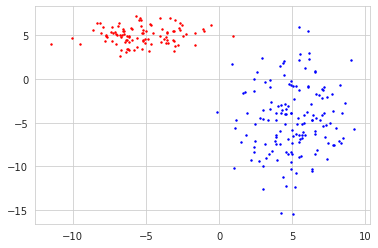

In [5]:
from matplotlib import cm
from scipy.stats import multivariate_normal

np.random.seed(3)

def make_cov_matrix(var):
    #t = np.random.randint(2, 5, size=(2, 2))
    #return t.dot(t.T)
    return np.diag(var)    

mean_0 = np.array([-5, 5])
sigma_0 = make_cov_matrix(var=[5, 1])
cl_0 = np.random.multivariate_normal(mean_0, sigma_0, size=(100,))

mean_1 = np.array([5, -5])
sigma_1 = make_cov_matrix(var=[3, 15])
cl_1 = np.random.multivariate_normal(mean_1, sigma_1, size=(150,))

plt.scatter(cl_0[:, 0], cl_0[:, 1], 2., color='r')
plt.scatter(cl_1[:, 0], cl_1[:, 1], 2., color='b')


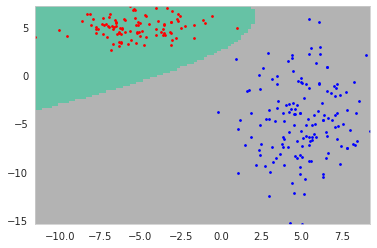

In [6]:
pdf_0 = multivariate_normal(np.mean(cl_0, axis=0), np.cov(cl_0.T))

pdf_1 = multivariate_normal(np.mean(cl_1, axis=0), np.cov(cl_1.T))

p_0 = 1. * len(cl_0) / (len(cl_0) + len(cl_1))
p_1 = 1. - p_0

def a(x):  
    t_0 = p_0 * pdf_0.pdf(x)  
    t_1 = p_1 * pdf_1.pdf(x)    
    
    return np.argmax([t_0, t_1])

data = np.vstack((cl_0, cl_1))
minX, maxX = data[:, 0].min(), data[:, 0].max()
minY, maxY = data[:, 1].min(), data[:, 1].max()
xx, yy = np.meshgrid(np.linspace(minX, maxX, 100), 
                     np.linspace(minY, maxY, 100))
            
zz = np.array([a(x) for x in np.c_[xx.ravel(), yy.ravel()]])

plt.xlim((minX, maxX))
plt.ylim((minY, maxY))

plt.pcolormesh(xx, yy, zz.reshape(xx.shape), cmap=cm.get_cmap('Set2'))
plt.scatter(cl_0[:, 0], cl_0[:, 1], 3., color='r')
plt.scatter(cl_1[:, 0], cl_1[:, 1], 3., color='b')